# Libraries Import

In [3]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading the Datafile

In [4]:
# Load the datasets
jj_df = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /jj.csv")
amzn_df = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")

# Display the first few rows of Johnson & Johnson data
jj_df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [5]:
jj_df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [6]:
# Rename the column to 'Sales' and process the 'Date' column
jj_df.columns = ['Date', 'Sales']
jj_df.set_index('Date', inplace=True)
jj_df.index = pd.to_datetime(jj_df.index)

# Display the processed Johnson & Johnson data
print(jj_df)

            Sales
Date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
...           ...
1979-10-01   9.99
1980-01-01  16.20
1980-04-01  14.67
1980-07-02  16.02
1980-10-01  11.61

[84 rows x 1 columns]


# Amazon Data

In [7]:
# Retain only relevant columns in Amazon dataset
amzn_df = amzn_df[['Date', 'Close']]
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)

# Time Series Graph

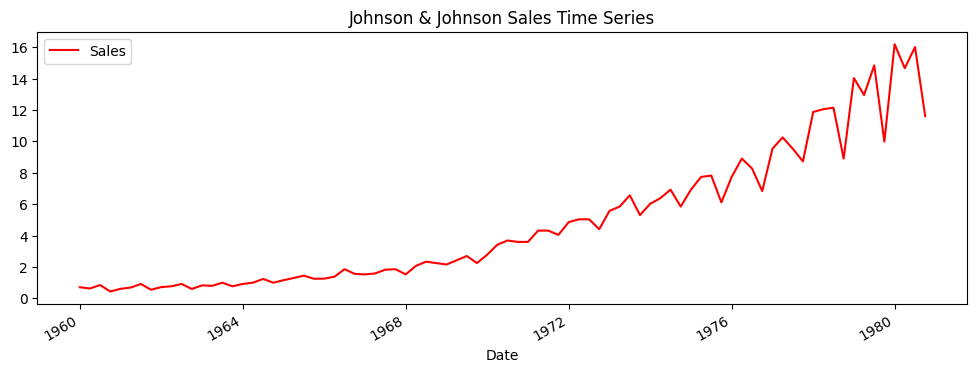

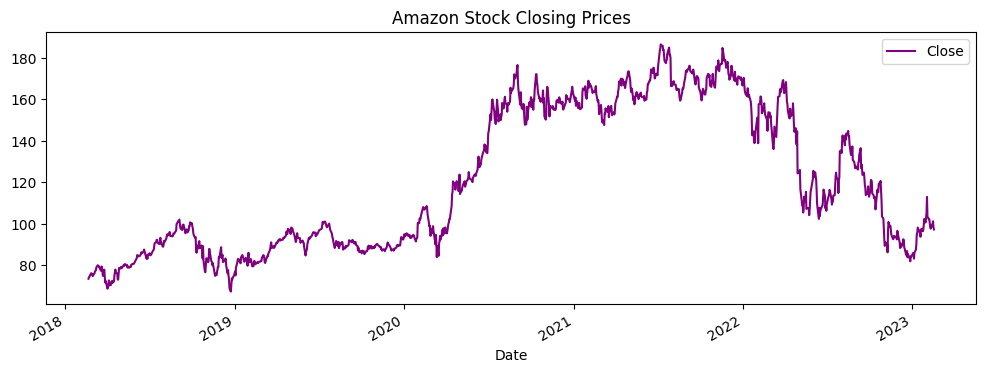

In [8]:
# Visualize Johnson & Johnson sales time series (red)
jj_df.plot(title='Johnson & Johnson Sales Time Series', figsize=(12, 4), color='red')
plt.show()

# Visualize Amazon closing price time series (purple)
amzn_df.plot(title='Amazon Stock Closing Prices', figsize=(12, 4), color='purple')
plt.show()

# Stationarity Testing and Differencing

In [9]:
# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test Result for {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Series is Stationary' if result[1] < 0.05 else 'Series is Non-stationary')

# Conduct ADF test on original series
adf_test(jj_df['Sales'], 'Johnson & Johnson Sales')
adf_test(amzn_df['Close'], 'Amazon Closing Price')

ADF Test Result for Johnson & Johnson Sales
ADF Statistic: 2.7420165734574744
p-value: 1.0
Series is Non-stationary
ADF Test Result for Amazon Closing Price
ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Series is Non-stationary


# first-order differencing

In [10]:
# Apply first-order differencing to achieve stationarity
jj_diff = jj_df['Sales'].diff().dropna()
amzn_diff = amzn_df['Close'].diff().dropna()

# Run ADF test again after differencing
adf_test(jj_diff, 'Johnson & Johnson Sales (Differenced)')
adf_test(amzn_diff, 'Amazon Closing Price (Differenced)')

ADF Test Result for Johnson & Johnson Sales (Differenced)
ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305
Series is Non-stationary
ADF Test Result for Amazon Closing Price (Differenced)
ADF Statistic: -36.25077933242776
p-value: 0.0
Series is Stationary


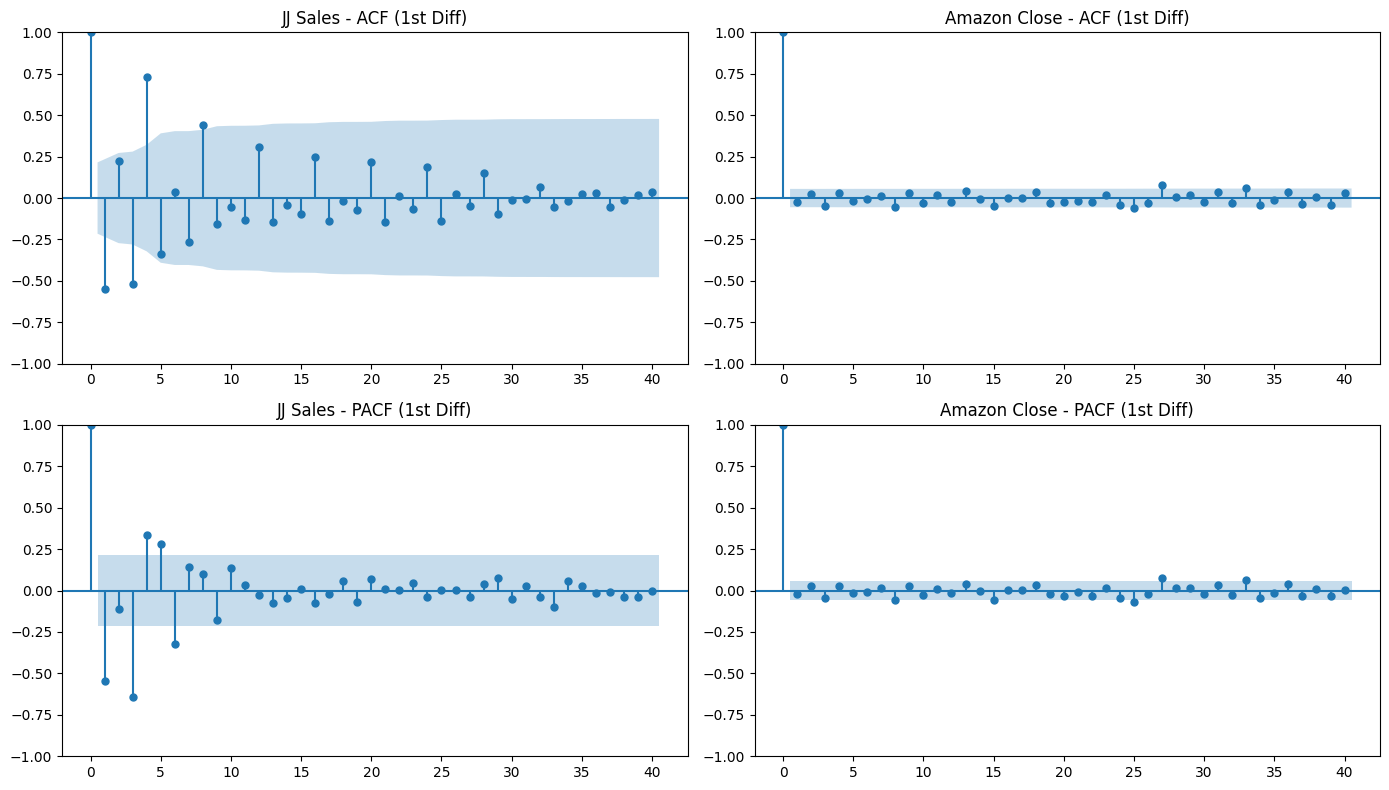

In [11]:
# Plot ACF and PACF for differenced series
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Johnson & Johnson ACF and PACF
plot_acf(jj_diff, ax=ax[0, 0], lags=40)
ax[0, 0].set_title("JJ Sales - ACF (1st Diff)")

plot_pacf(jj_diff, ax=ax[1, 0], lags=40, method='ywm')
ax[1, 0].set_title("JJ Sales - PACF (1st Diff)")

# Amazon ACF and PACF
plot_acf(amzn_diff, ax=ax[0, 1], lags=40)
ax[0, 1].set_title("Amazon Close - ACF (1st Diff)")

plot_pacf(amzn_diff, ax=ax[1, 1], lags=40, method='ywm')
ax[1, 1].set_title("Amazon Close - PACF (1st Diff)")

plt.tight_layout()
plt.show()

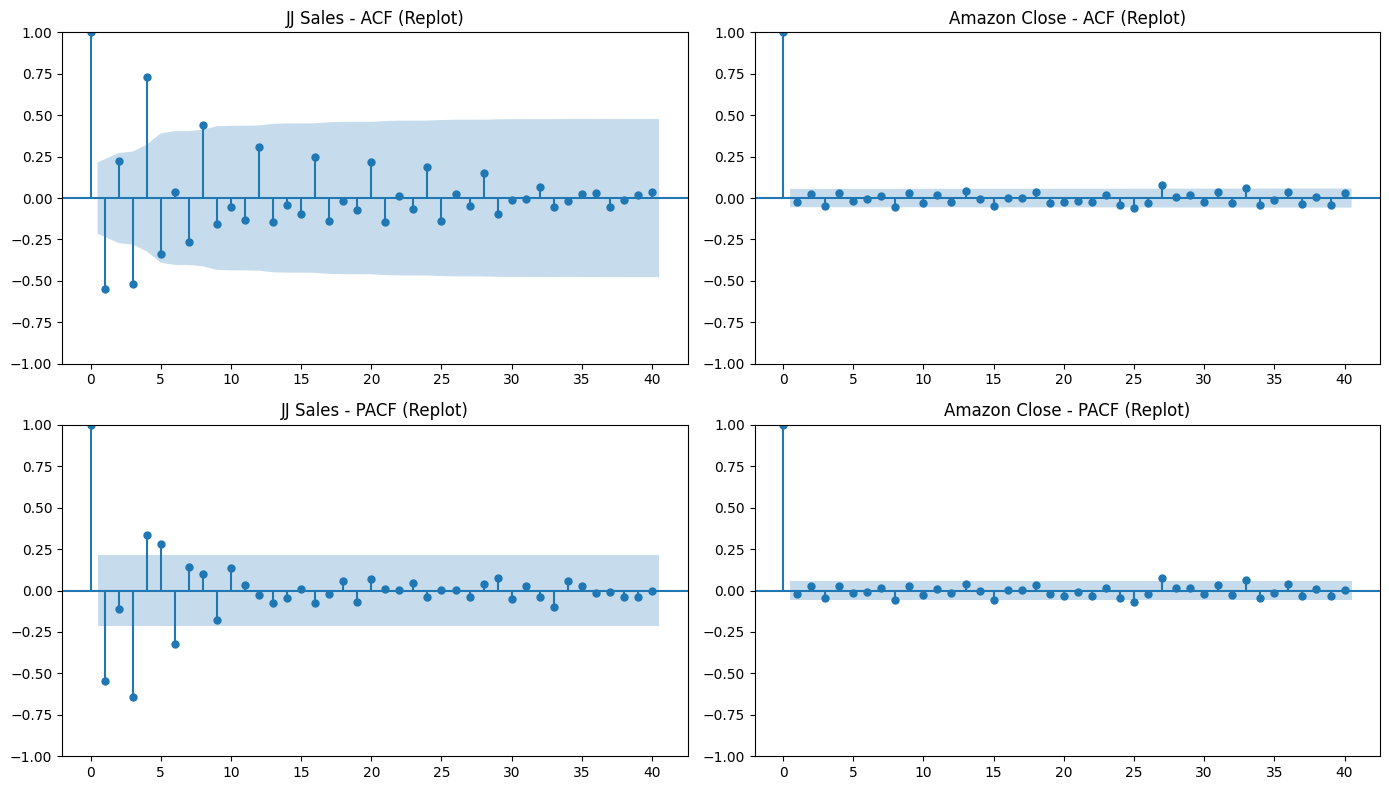

In [12]:
# (Optional) Re-plot ACF and PACF to ensure consistent views (if required)
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Re-confirming ACF and PACF plots for both series
plot_acf(jj_diff, ax=ax[0, 0], lags=40)
ax[0, 0].set_title("JJ Sales - ACF (Replot)")

plot_pacf(jj_diff, ax=ax[1, 0], lags=40, method='ywm')
ax[1, 0].set_title("JJ Sales - PACF (Replot)")

plot_acf(amzn_diff, ax=ax[0, 1], lags=40)
ax[0, 1].set_title("Amazon Close - ACF (Replot)")

plot_pacf(amzn_diff, ax=ax[1, 1], lags=40, method='ywm')
ax[1, 1].set_title("Amazon Close - PACF (Replot)")

plt.tight_layout()
plt.show()

# ARIMA (ARMA) Modelling and Forecast

In [13]:
# Fit an ARIMA model to Johnson & Johnson sales data
# (p, d, q) = (1, 1, 1) is a placeholder – you can optimize these using AIC/BIC
jj_arima_model = ARIMA(jj_df['Sales'], order=(1, 1, 1))
jj_arima_fit = jj_arima_model.fit()

# Display model summary
print("Johnson & Johnson ARIMA Model Summary:")
print(jj_arima_fit.summary())

# Fit an ARIMA model to Amazon closing stock price
# (p, d, q) = (1, 1, 1) can be refined after checking ACF/PACF or via grid search
amzn_arima_model = ARIMA(amzn_df['Close'], order=(1, 1, 1))
amzn_arima_fit = amzn_arima_model.fit()

# Display model summary
print("\nAmazon ARIMA Model Summary:")
print(amzn_arima_fit.summary())

Johnson & Johnson ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -128.371
Date:                Fri, 11 Apr 2025   AIC                            262.742
Time:                        16:13:09   BIC                            269.998
Sample:                             0   HQIC                           265.657
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3277      0.090     -3.657      0.000      -0.503      -0.152
ma.L1         -0.4313      0.093     -4.662      0.000      -0.613      -0.250
sigma2       

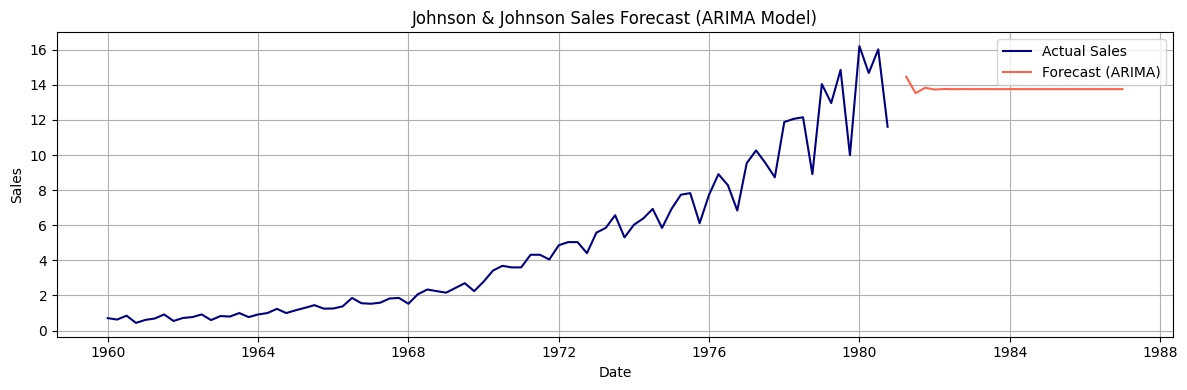

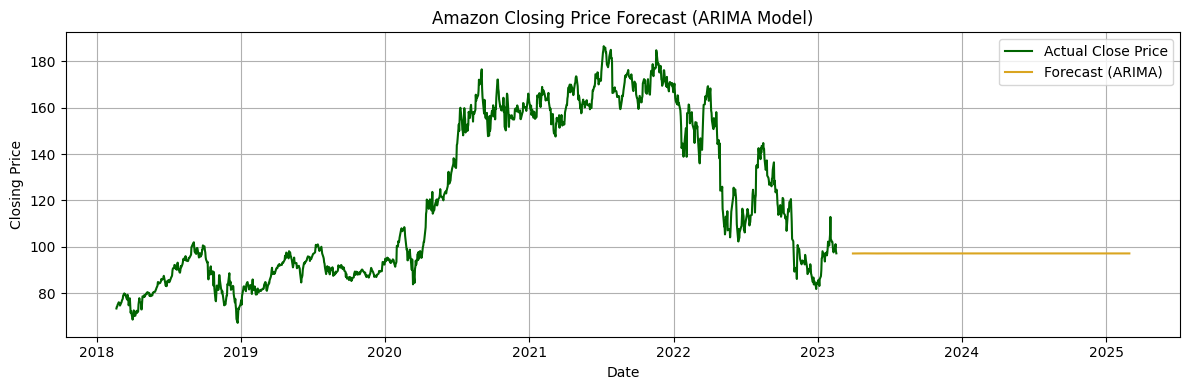

In [14]:
# -----------------------------
# ARIMA Forecast Plots with Updated Colors and Variable Names
# -----------------------------

# Forecasting 24 time steps ahead
jj_sales_forecast_24 = jj_arima_fit.forecast(steps=24)
amzn_close_forecast_24 = amzn_arima_fit.forecast(steps=24)

# Plot Johnson & Johnson Sales Forecast (Quarterly)
plt.figure(figsize=(12, 4))
plt.plot(jj_df['Sales'], label='Actual Sales', color='navy')
plt.plot(pd.date_range(jj_df.index[-1], periods=25, freq='Q')[1:],
         jj_sales_forecast_24, label='Forecast (ARIMA)', color='tomato')
plt.title('Johnson & Johnson Sales Forecast (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Amazon Stock Closing Price Forecast (Monthly)
plt.figure(figsize=(12, 4))
plt.plot(amzn_df['Close'], label='Actual Close Price', color='darkgreen')
plt.plot(pd.date_range(amzn_df.index[-1], periods=25, freq='M')[1:],
         amzn_close_forecast_24, label='Forecast (ARIMA)', color='goldenrod')
plt.title('Amazon Closing Price Forecast (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Neural Network Forecasting (LSTM / GRU)

In [15]:
# -----------------------------
# Function to Structure Data for RNN Input
# -----------------------------
def create_rnn_sequences(series, n_lags=12):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# -----------------------------
# Normalize and Prepare Time Series Data for RNN Models
# -----------------------------

# Johnson & Johnson Sales - Normalization and Sequence Generation
scaler_jj_sales = MinMaxScaler()
jj_sales_scaled = scaler_jj_sales.fit_transform(jj_df['Sales'].values.reshape(-1, 1))
X_jj_sales, y_jj_sales = create_rnn_sequences(jj_sales_scaled)

# Amazon Closing Price - Normalization and Sequence Generation
scaler_amzn_close = MinMaxScaler()
amzn_close_scaled = scaler_amzn_close.fit_transform(amzn_df['Close'].values.reshape(-1, 1))
X_amzn_close, y_amzn_close = create_rnn_sequences(amzn_close_scaled)

# Reshape input data for RNN [samples, timesteps, features]
X_jj_sales = X_jj_sales.reshape((X_jj_sales.shape[0], X_jj_sales.shape[1], 1))
X_amzn_close = X_amzn_close.reshape((X_amzn_close.shape[0], X_amzn_close.shape[1], 1))


In [17]:
# -----------------------------
# Build RNN Model (Supports LSTM or GRU)
# -----------------------------
def build_rnn_model(input_shape, model_type='LSTM'):
    """
    Builds and compiles an RNN model using either LSTM or GRU units.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).
        model_type (str): Either 'LSTM' or 'GRU'.

    Returns:
        model (tf.keras.Model): Compiled RNN model.
    """
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(64, input_shape=input_shape, return_sequences=False))
    else:
        raise ValueError("model_type must be either 'LSTM' or 'GRU'")

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse')

    return model


In [18]:
def train_and_forecast_rnn(X, y, scaler, model_type='LSTM', forecast_steps=24):
    """
    Train an RNN model (LSTM or GRU) and forecast future values.

    Parameters:
        X (np.array): Input features of shape [samples, timesteps, 1]
        y (np.array): Target values
        scaler (MinMaxScaler): Scaler used for inverse transforming predictions
        model_type (str): 'LSTM' or 'GRU'
        forecast_steps (int): Number of future time steps to predict

    Returns:
        np.array: Forecasted values in original scale
    """
    # Build and compile the model
    model = build_rnn_model((X.shape[1], 1), model_type)

    # Set early stopping to avoid overfitting
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    # Train the model with validation split
    model.fit(
        X, y,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Prepare last sequence for recursive forecasting
    last_input = X[-1]
    predictions = []

    for _ in range(forecast_steps):
        next_pred = model.predict(last_input.reshape(1, -1, 1), verbose=0)[0]
        predictions.append(next_pred)
        last_input = np.append(last_input[1:], next_pred).reshape(-1, 1)

    # Reverse normalization to get values in original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions


In [19]:
# ----------------------------------
# Johnson & Johnson Forecasts
# ----------------------------------
print("Training LSTM model for Johnson & Johnson Sales...")
jj_lstm_forecast_24 = train_and_forecast_rnn(X_jj_sales, y_jj_sales, scaler_jj_sales, model_type='LSTM')

print("Training GRU model for Johnson & Johnson Sales...")
jj_gru_forecast_24 = train_and_forecast_rnn(X_jj_sales, y_jj_sales, scaler_jj_sales, model_type='GRU')

# ----------------------------------
# Amazon Forecasts
# ----------------------------------
print(" Training LSTM model for Amazon Closing Prices...")
amzn_lstm_forecast_24 = train_and_forecast_rnn(X_amzn_close, y_amzn_close, scaler_amzn_close, model_type='LSTM')

print("Training GRU model for Amazon Closing Prices...")
amzn_gru_forecast_24 = train_and_forecast_rnn(X_amzn_close, y_amzn_close, scaler_amzn_close, model_type='GRU')


Training LSTM model for Johnson & Johnson Sales...
Training GRU model for Johnson & Johnson Sales...
 Training LSTM model for Amazon Closing Prices...
Training GRU model for Amazon Closing Prices...


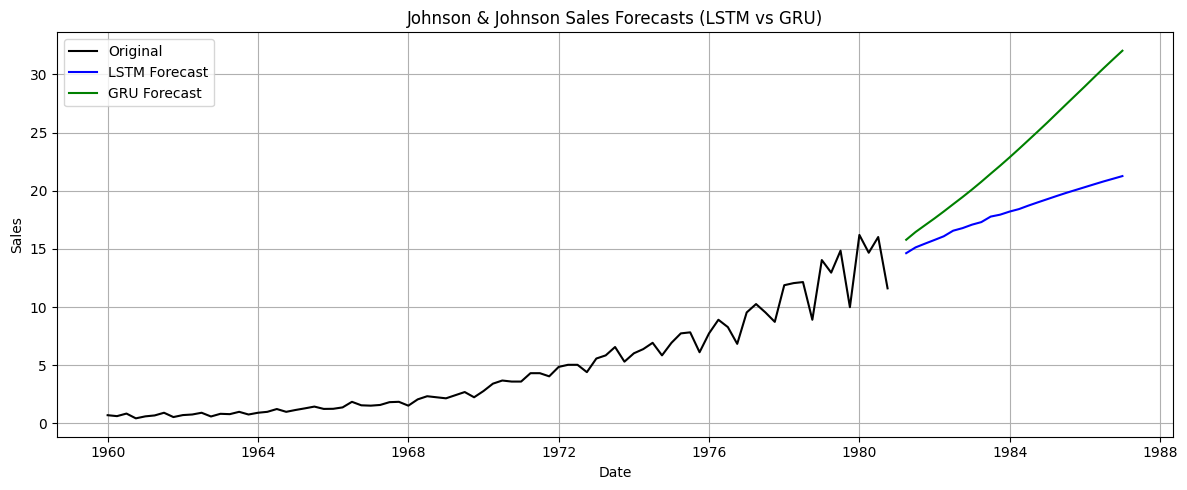

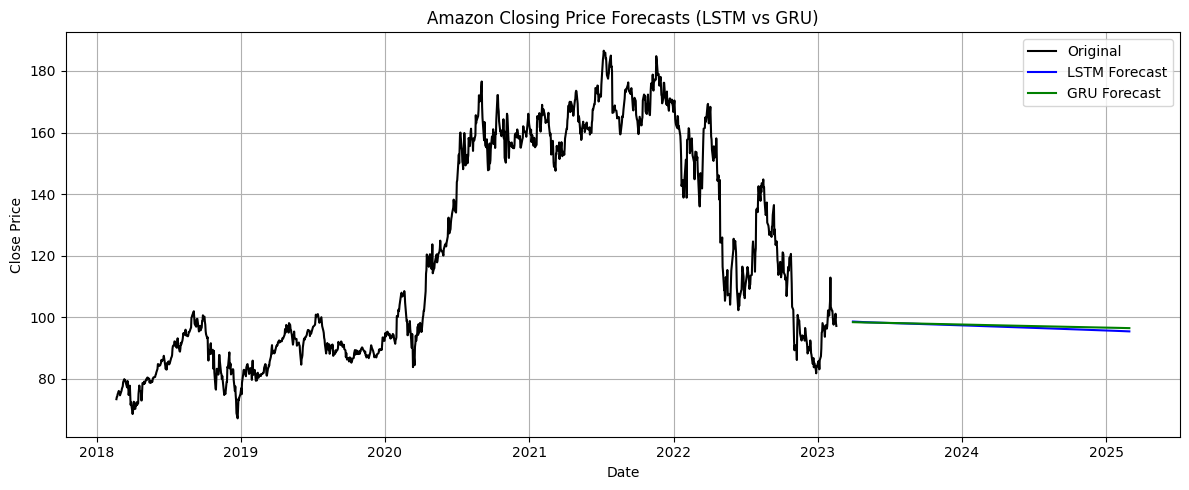

In [ ]:
# -----------------------------
# Plot Johnson & Johnson Forecasts (LSTM vs GRU)
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(jj_df['Sales'], label='Actual Sales', color='black')
plt.plot(pd.date_range(jj_df.index[-1], periods=25, freq='Q')[1:],
         jj_lstm_forecast_24, label='LSTM Forecast', color='royalblue')
plt.plot(pd.date_range(jj_df.index[-1], periods=25, freq='Q')[1:],
         jj_gru_forecast_24, label='GRU Forecast', color='seagreen')
plt.title('Johnson & Johnson Sales Forecasts (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot Amazon Forecasts (LSTM vs GRU)
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(amzn_df['Close'], label='Actual Closing Price', color='black')
plt.plot(pd.date_range(amzn_df.index[-1], periods=25, freq='M')[1:],
         amzn_lstm_forecast_24, label='LSTM Forecast', color='darkorange')
plt.plot(pd.date_range(amzn_df.index[-1], periods=25, freq='M')[1:],
         amzn_gru_forecast_24, label='GRU Forecast', color='mediumvioletred')
plt.title('Amazon Closing Price Forecasts (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------
# Evaluation Function: Calculates MSE and MAE
# -----------------------------
def evaluate_model(true_values, predicted_values, model_name="Model"):
    """
    Evaluate prediction performance using MSE and MAE.

    Parameters:
        true_values (array-like): Ground truth values
        predicted_values (array-like): Forecasted values
        model_name (str): Identifier for the model being evaluated
    """
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    print(f"{model_name} -> MSE: {mse:.4f} | MAE: {mae:.4f}")

# -----------------------------
# Get True Values (Last 24 Time Steps)
# -----------------------------
jj_sales_true_last24 = jj_df['Sales'][-24:].values
amzn_close_true_last24 = amzn_df['Close'][-24:].values

# -----------------------------
# Evaluate Johnson & Johnson Forecasts
# -----------------------------
evaluate_model(jj_sales_true_last24, jj_lstm_forecast_24, "JJ LSTM")
evaluate_model(jj_sales_true_last24, jj_gru_forecast_24, "JJ GRU")

# -----------------------------
# Evaluate Amazon Forecasts
# -----------------------------
evaluate_model(amzn_close_true_last24, amzn_lstm_forecast_24, "Amazon LSTM")
evaluate_model(amzn_close_true_last24, amzn_gru_forecast_24, "Amazon GRU")


JJ LSTM -> MSE: 61.4291, MAE: 7.6529
JJ GRU -> MSE: 175.9177, MAE: 12.9399
Amazon LSTM -> MSE: 25.6768, MAE: 3.9461
Amazon GRU -> MSE: 22.3204, MAE: 3.5251
